In [1]:
import math
import torch
import gpytorch
#import spectralgp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

## Introduction

In this notebook, we how to train a functional kernel learning model, training on a simple function. We'll be modeling the function

\begin{align*}
  y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.2)
\end{align*}

with 11 training examples, and testing on 51 test examples.

For more mathematical detail, please see the paper Functional Distributions over Kernels (NeurIPS 2019).

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf


#### Set up the GPyTorch Model with Spectral GP kernel
Using the same framework as standard GPyTorch models, we merely drop-in the spectral GP kernel as the covar module

The `initialize_from_data` method does some pre-training on the latent model using the log-periodogram of data as training targets.

For specifics on the components of GPyTorch models we refer to the [GPyTorch Documentation](https://gpytorch.readthedocs.io/en/latest/index.html)

In [3]:
class SpectralModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, **kwargs):
        super(SpectralModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralGPKernel(**kwargs)
        self.covar_module.initialize_from_data(train_x, train_y, **kwargs)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


#### Generate training data and Build GP Model
Generate points in [0, 5] and a sine wave to serve as the response, then split into training and test data.

Pass this data into the GP model from above along with a likelihood

In [4]:
nx = 200
split = 150
full_x = torch.linspace(0, 5, nx)
full_y = torch.sin(2 * full_x)

train_x = full_x[:split]
train_y = full_y[:split]

test_x = full_x[(split - nx):]
test_y = full_y[(split - nx):]

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-4))
model = SpectralModel(train_x, train_y, likelihood, nomg=100)


None


#### Set up sampling factories

In the inference procedure we consider fixing the latent GP observation and doing gradient descent updates on the hyperparameters, then fixing the hyperparameters and using elliptical slice sampling to update the latent GP. 

The `ss_factory` generates a "factory" that fixes the latent GP and computes the loss function of the hyperparameters

### Set up Alternating Sampler

In [6]:
n_iters = 10
ess_iters = 5
optim_iters = 5

In [7]:
alt_sampler = gpytorch.samplers.AlternatingSampler(
    [model], [likelihood], 
    gpytorch.samplers.ss_factory, [gpytorch.samplers.ess_factory],
    totalSamples=n_iters, numInnerSamples=ess_iters, numOuterSamples=optim_iters
    )
alt_sampler.run();


Loss is:  tensor(-34.6295, grad_fn=<DivBackward0>)
Loss is:  tensor(-34.1212, grad_fn=<DivBackward0>)
Loss is:  tensor(-33.6220, grad_fn=<DivBackward0>)
Loss is:  tensor(-33.1319, grad_fn=<DivBackward0>)
Loss is:  tensor(-32.6513, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 1.2649612426757812
Loss is:  tensor(-32.1064, grad_fn=<DivBackward0>)
Loss is:  tensor(-31.6396, grad_fn=<DivBackward0>)
Loss is:  tensor(-31.1826, grad_fn=<DivBackward0>)
Loss is:  tensor(-30.7334, grad_fn=<DivBackward0>)
Loss is:  tensor(-30.2932, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 1
Seconds for Iteration 1 : 1.3638746738433838
Loss is:  tensor(-29.8550, grad_fn=<DivBackward0>)
Loss is:  tensor(-29.4307, grad_fn=<DivBackward0>)
Loss is:  tensor(-29.0139, grad_fn=<DivBackward0>)
Loss is:  tensor(-28.6046, grad_fn=<DivBackward0>)
Loss is:  tensor(-28.2028, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 2
Seconds for Iteration 2 : 0.8321239948272705
Loss is:  tensor(-27.7029, grad_fn

#### Process the outputs
The alternating sampler provides a good set of hyperparamters (already attached to the model) and samples of the spectral density of the covariance function.

To generate predictions we look at the last samples of the alterntating sampler and generate covariance functions from each of these samples. 

In the below plotting we show 10 predictions: one prediction for each of the last 10 sampled log-spectral densities taken from the alternating sampler.

In [8]:
model.eval()
n_samples = 10
spectrum_samples = alt_sampler.gsampled[0][0,:, -10:].detach()

predictions = torch.zeros(len(full_x), 10) # predictions for each sample
upper_bds = torch.zeros(len(full_x), 10) # upper conf. bd for each sample
lower_bds = torch.zeros(len(full_x), 10) # lower conf. bd for each sample

with torch.no_grad():
    for ii in range(n_samples):
        model.covar_module.set_latent_params(spectrum_samples[:, ii])
        model.set_train_data(train_x, train_y) # to clear out the cache
        pred_dist = model(full_x) 
        lower_bds[:, ii], upper_bds[:, ii] = pred_dist.confidence_region()
        predictions[:, ii] = pred_dist.mean


#### Now Generate the Plot

We now predict on the test set, using the last several samples that we stored previously.

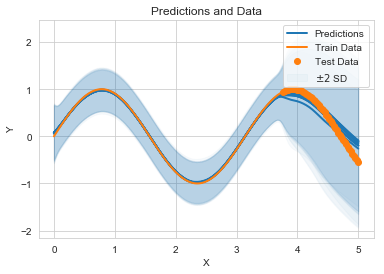

In [10]:
sns.set_style("whitegrid")
colors = cm.get_cmap("tab10")
## plot the predictions ##
plt.plot(full_x.numpy(), predictions[:, 0].detach().numpy(), label="Predictions",
         color=colors(0), linewidth=2)
plt.plot(full_x.numpy(), predictions.detach().numpy(), linewidth=2, 
         color=colors(0))

## Shade region +/- 2 SD around the mean ##
plt.fill_between(full_x.numpy(), lower_bds[:, 0].detach().numpy(), 
                 upper_bds[:, 0].detach().numpy(),
                 color=colors(0), alpha=0.03, label = r"$\pm 2$ SD")
for ii in range(n_samples):
    plt.fill_between(full_x.numpy(), lower_bds[:, ii].detach().numpy(), 
                     upper_bds[:, ii].detach().numpy(), 
                     color=colors(0), alpha=0.03)
    
## plot data ##
plt.plot(train_x.numpy(), train_y.numpy(), color=colors(1),
        linewidth=2, label="Train Data")
plt.plot(test_x.numpy(), test_y.numpy(), color=colors(1),
        linestyle="None", marker=".", markersize=12,
        label="Test Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Predictions and Data")
plt.legend()
plt.show()


Finally, we show several samples of the estimated spectral density, captured from the latent Gaussian process.

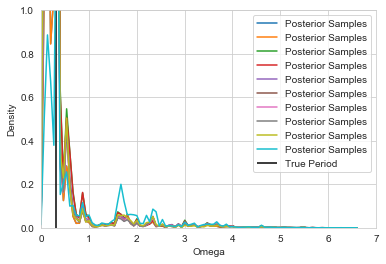

In [11]:
plt.plot(model.covar_module.omega.numpy(), spectrum_samples.exp().numpy(), label = 'Posterior Samples')
plt.xlabel('Omega')
plt.ylabel('Density')
plt.xlim((0, 7))
plt.ylim((0,1))
plt.vlines(2/(2*3.14159),ymin=0, ymax=10, label = 'True Period')
plt.legend()